# [《100天成为风控专家》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2ZAoFMNREbOv3DutKsoIi9Vlfky) 规则篇-规则生成(1)-单变量Python代码实操

In [2]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from matplotlib import pyplot as plt
%matplotlib inline
## 设置属性防止中文乱码
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

In [10]:
import sklearn
import matplotlib as mpl
print('pandas:',pd.__version__)
print('numpy:',np.__version__)
print('sklearn:',sklearn.__version__)
print('matplotlib:',mpl.__version__)
print('scorecardpy:',sc.__version__)

pandas: 2.0.0
numpy: 1.23.5
sklearn: 1.3.2
matplotlib: 3.7.1
scorecardpy: 0.1.9.7


# 一、变量初筛

In [5]:
def simple_statics():
    # 读入数据
    df = pd.read_csv('data_rule.csv')
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), 
                      (df[col].isnull()).sum() * 100 / df.shape[0],
                      (df[col]==-999).sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100, 
                      df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage_of_null','Percentage_of_999',
                                            'Percentage_of_mode', 'Type'])
    stats_df.sort_values('Unique_values', ascending=False, inplace=True)
    return stats_df

In [6]:
sts_df = simple_statics()
sts_df.head(100)

Feature  Unique_values  Percentage_of_null  Percentage_of_999   
0               lmt           1718                 0.0           0.000000  \
1               job             13                 0.0           0.000000   
3        basicLevel              6                 0.0           1.712503   
2  ncloseCreditCard              3                 0.0           0.235554   
4   unpayNormalLoan              3                 0.0           0.235554   
5            target              2                 0.0           0.000000   

   Percentage_of_mode     Type  
0            2.160889  float64  
1           47.766021    int64  
3           34.837043    int64  
2           79.341660    int64  
4           84.530671    int64  
5           99.273644    int64

- 这里的变量中，只有`lmt`是数值类型，其余变量属于离散类型；
- 数据中没有空值，但有-999的情况，也是空值的意思；缺失率水平都比较低；
- `ncloseCreditCard`和`unpayNormalLoan`众数占比略高，变量是否有区分性还需进一步判断；

# 二、规则阈值制定方法

## 1. 基于分箱的IV分析法

- 使用`scorecardpy`进行分箱，算法选择为决策树`tree`，也可以改为卡方分箱`chimerge`。默认分箱最小占比为5%。

- 如果对`scorecardpy`不熟悉可以将下面的单元格按`“ctrl+/”`取消注释，然后运行查看参数定义。

>Github链接：https://github.com/ShichenXie/scorecardpy

In [7]:
# ?sc.woebin

In [8]:
def cal_iv(df0, var_iv, y_flag, breaks_list, stop_limit0):
    """
    分箱并计算IV值
    :param df0: DF格式的数据
    :param var_iv: 需要计算iv的列的列表
    :param y_flag: y标签
    :return iv_df: variable和iv值
    :return bins_base: 字典，分箱值
    """
    iv_list = []
    bins_base = sc.woebin(df0[var_iv + [y_flag]], y=y_flag, breaks_list=breaks_list, method='tree', stop_limit=stop_limit0)
    # 分箱可视化图
    bins_show = sc.woebin_plot(bins_base)
    for col, iv_df_i in bins_base.items():
        iv_df_i['bad_distr'] = iv_df_i['bad']/iv_df_i['bad'].sum() #边际坏占比
        iv_df_i['good_distr'] = iv_df_i['good']/iv_df_i['good'].sum() #边际好占比
        iv_df_i = iv_df_i.rename(columns={'variable':'变量名','bin':'分箱','count':'分箱客户数','count_distr':'分箱客户数占比',
                                         'good':'好客户数','bad':'坏客户数','badprob':'区间坏账率','bad_distr':'边际坏客户占比',
                                         'good_distr':'边际好客户占比'})
        iv_df_i = iv_df_i[['变量名','分箱','分箱客户数','好客户数','坏客户数','分箱客户数占比','边际好客户占比','边际坏客户占比',
                           '区间坏账率','woe','bin_iv','total_iv']]
        bins_base[col] = iv_df_i
        iv_list.append((col,iv_df_i['total_iv'][0])) 
    iv_df = pd.DataFrame.from_records(iv_list,columns=['variable','iv_train'])
    iv_df = iv_df.sort_values(by=['iv_train'], ascending=False)
    return iv_df, bins_base

该函数返回两个对象：
- `iv_df`是所有变量对应IV值的dataframe；
- `bins_base`是所有变量的分箱结果；

['basicLevel', 'job', 'lmt', 'ncloseCreditCard', 'unpayNormalLoan']
[INFO] creating woe binning ...


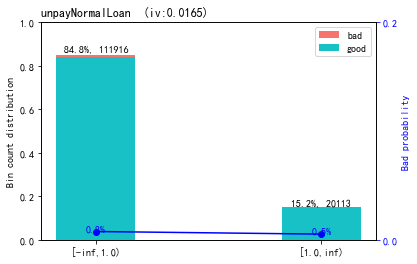

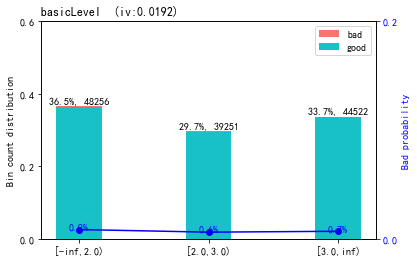

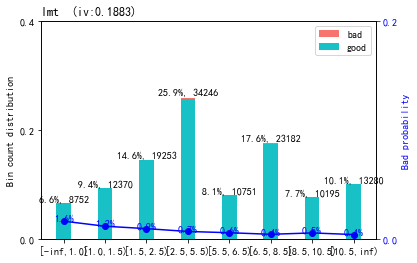

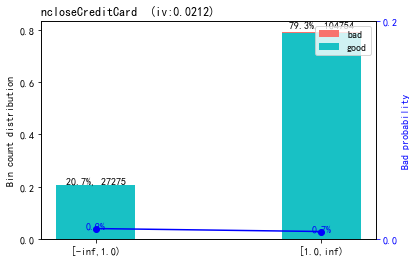

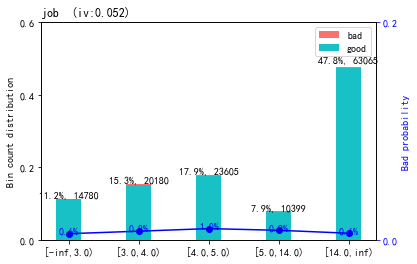

In [9]:
df = pd.read_csv('data_rule.csv')
# 变量列表
names = df.columns.difference(['target']).tolist()
print(names)
# 计算iv
iv_table, bins_df = cal_iv(df, names, y_flag='target', breaks_list={}, stop_limit0=0)

### 1.1. 基于IV值筛选变量

IV指标的一般评判标准：
- `iv < 0.1`: 较弱
- `0.1 <= iv < 0.3`: 强
- `iv > 0.3`: 非常强

In [18]:
iv_table

variable  iv_train
2               lmt  0.188267
3               job  0.051966
1  ncloseCreditCard  0.021248
4        basicLevel  0.019202
0   unpayNormalLoan  0.016489

筛选IV大于0.1的变量

In [19]:
iv_table[iv_table['iv_train']>0.1]

variable  iv_train
2      lmt  0.188267

### 1.2. 查看变量分箱

In [20]:
bins_df['lmt']

变量名          分箱  分箱客户数   好客户数  坏客户数   分箱客户数占比   边际好客户占比   边际坏客户占比   
0  lmt  [-inf,1.0)   8752   8610   142  0.066288  0.065690  0.148071  \
1  lmt   [1.0,1.5)  12370  12227   143  0.093692  0.093286  0.149114   
2  lmt   [1.5,2.5)  19253  19073   180  0.145824  0.145518  0.187696   
3  lmt   [2.5,5.5)  34246  34015   231  0.259382  0.259518  0.240876   
4  lmt   [5.5,6.5)  10751  10691    60  0.081429  0.081567  0.062565   
5  lmt   [6.5,8.5)  23182  23086    96  0.175583  0.176135  0.100104   
6  lmt  [8.5,10.5)  10195  10140    55  0.077218  0.077363  0.057351   
7  lmt  [10.5,inf)  13280  13228    52  0.100584  0.100923  0.054223   

      区间坏账率       woe    bin_iv  total_iv  
0  0.016225  0.812743  0.066954  0.188267  
1  0.011560  0.469038  0.026185  0.188267  
2  0.009349  0.254524  0.010735  0.188267  
3  0.006745 -0.074543  0.001390  0.188267  
4  0.005581 -0.265217  0.005040  0.188267  
5  0.004141 -0.565038  0.042960  0.188267  
6  0.005395 -0.299314  0.005990  0.188267  
7  0.003916 -0.621252  0.029012  0.188267

In [21]:
# 整体样本坏客户浓度
df['target'].mean()

0.0072635557339675375

以上分箱我们观察到：
- badprob(区间坏账率)有明显排序性，随着lmt值变小单调递增；
- lmt含义为预授信金额，数值越小资质越差，风险越高，符合业务可解释性；
- 第一箱`[-inf,1.0)`的区间坏账率最高，达到**1.622%**;
- 如果以第一箱为规则阈值，命中率为 **6.63%** ，抓住 **14.8%** 的坏客户（142个），误拒 **6.56%** 的好客户

### 1.3. 分箱调整

第一箱的breaks为1，我们尝试其他的分箱点。

[INFO] creating woe binning ...


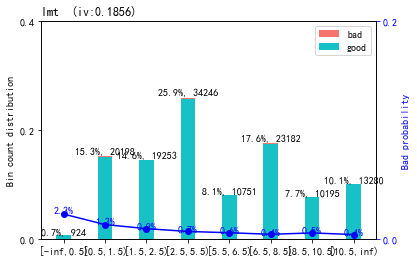

In [23]:
names = iv_table.loc[iv_table['iv_train']>0.1,'variable'].tolist()
# 调整分箱点
adj = {
    'lmt':[0.5,1.5,2.5,5.5,6.5,8.5,10.5]
}
# 重新定义分箱
_, bins_adj = cal_iv(df, names, y_flag='target', breaks_list=adj, stop_limit0=0)

In [24]:
bins_adj['lmt']

变量名          分箱  分箱客户数   好客户数  坏客户数   分箱客户数占比   边际好客户占比   边际坏客户占比   
0  lmt  [-inf,0.5)    924    903    21  0.006998  0.006889  0.021898  \
1  lmt   [0.5,1.5)  20198  19934   264  0.152982  0.152087  0.275287   
2  lmt   [1.5,2.5)  19253  19073   180  0.145824  0.145518  0.187696   
3  lmt   [2.5,5.5)  34246  34015   231  0.259382  0.259518  0.240876   
4  lmt   [5.5,6.5)  10751  10691    60  0.081429  0.081567  0.062565   
5  lmt   [6.5,8.5)  23182  23086    96  0.175583  0.176135  0.100104   
6  lmt  [8.5,10.5)  10195  10140    55  0.077218  0.077363  0.057351   
7  lmt  [10.5,inf)  13280  13228    52  0.100584  0.100923  0.054223   

      区间坏账率       woe    bin_iv  total_iv  
0  0.022727  1.156396  0.017356  0.185585  
1  0.013071  0.593363  0.073102  0.185585  
2  0.009349  0.254524  0.010735  0.185585  
3  0.006745 -0.074543  0.001390  0.185585  
4  0.005581 -0.265217  0.005040  0.185585  
5  0.004141 -0.565038  0.042960  0.185585  
6  0.005395 -0.299314  0.005990  0.185585  
7  0.003916 -0.621252  0.029012  0.185585

以上分箱我们观察到：
- 第一箱`[-inf,0.5)`的区间坏账率最高，达到 **2.27%** ；
- 但如果以第一箱为规则阈值，命中率为 **0.7%** ，只抓住 **2.19%** 的坏客户（21个），误拒 **0.69%** 的好客户；

## 2. 极端值检测

以下的分位点数在大小两端各选了4个，一共8个极端值分位点。一般情况下默认用这组分位点即可。

In [25]:
def rule_evaluate(selected_df, total_df, target):
    """
    规则评估函数
    :param selected_df: 子特征列表
    :param total_df: 输入的dataframe
    :param target: 目标变量
    """
    # 命中规则的子群体指标统计
    hit_size = selected_df.shape[0]    
    hit_bad_size = selected_df[target].sum()
    hit_bad_rate = selected_df[target].mean()
 
    # 总体指标统计
    total_size = total_df.shape[0] 
    total_bad_size = total_df[target].sum()
    total_bad_rate = total_df[target].mean()
    
    hit_rate = hit_size / total_size     # 命中率（支持度）
    lift = hit_bad_rate / total_bad_rate # 提升度
    bad_prob = hit_bad_size/total_bad_size
    good_prob = (hit_size-hit_bad_size)/(total_size-total_bad_size)
    
    res = [total_size, total_bad_size, total_bad_rate, 
           hit_rate, hit_size, hit_bad_size, hit_bad_rate, bad_prob, good_prob, lift]
    return res

def rule_discover(input_df, var, target, q_list=[0.005, 0.01, 0.02, 0.98, 0.99, 0.995]):
    """
    规则挖掘
    :param input_df: 输入的dataframe
    :param var: 变量名
    :param target: 目标变量
    :param q_list: 分位数列表
    :return result_df: 基于所有分位点制定规则的dataframe
    """
    sub_df = input_df[input_df[var].notnull()].reset_index(drop=True)
    miss_df = input_df[input_df[var].isnull()].reset_index(drop=True)
    
    res_list = []
    rule = "is missing"
    res = rule_evaluate(miss_df, input_df, target)
    res_list.append([var, rule] + res)
    
    # 分位数列表，用以控制目标群体规模
    for q in q_list:
        threshold = sub_df[var].quantile(q)
        rule = ""
        if q < 0.2:
            temp = sub_df.query("{0} <= @threshold".format(var))
            rule += "<= {0}".format(threshold)
        else:
            temp = sub_df.query("{0} >= @threshold".format(var))
            rule += ">= {0}".format(threshold)

        res = rule_evaluate(temp, input_df, target)
        res_list.append([var, rule] + res)

    result_df = pd.DataFrame(res_list, columns=['var', 'rule', 
                             'total_size', 'total_bad_size', 'total_bad_rate', 
                             'hit_rate', 'hit_size', 'hit_bad_size', 'hit_bad_rate', 'margin_bad_rate', 'margin_good_rate', 'lift'])
    return result_df

In [26]:
rule_df = pd.DataFrame()
lift_cutoff = 1.5 
hit_rate_down_cutoff = 0.01 #命中率最低值
hit_rate_up_cutoff = 0.06 #命中率最高值
bad_prob_down_cutoff = 0.1 #边际坏占比最低值

for i in names:
    # 调用规则挖掘函数，设置分位点列表
    rule_tmp = rule_discover(df, i, target = 'target', q_list=[0.005, 0.01, 0.02, 0.05, 0.95, 0.98, 0.99, 0.995])
    display(rule_tmp) #展示全部分位点规则
    # 筛选lift和hit_rate指标
    rule_tmp = rule_tmp[
        (rule_tmp['lift']>=lift_cutoff) \
        &(rule_tmp['hit_rate']>=hit_rate_down_cutoff) \
        # &(rule_tmp['margin_bad_rate']>=bad_prob_down_cutoff)
    ]
    rule_df = pd.concat([rule_df,rule_tmp],axis = 0)

var                   rule  total_size  total_bad_size  total_bad_rate   
0  lmt             is missing      132029             959        0.007264  \
1  lmt               <= 0.463      132029             959        0.007264   
2  lmt               <= 0.563      132029             959        0.007264   
3  lmt               <= 0.667      132029             959        0.007264   
4  lmt               <= 0.867      132029             959        0.007264   
5  lmt              >= 16.667      132029             959        0.007264   
6  lmt              >= 23.963      132029             959        0.007264   
7  lmt  >= 34.223760000000034      132029             959        0.007264   
8  lmt              >= 42.963      132029             959        0.007264   

   hit_rate  hit_size  hit_bad_size  hit_bad_rate  margin_bad_rate   
0  0.000000         0             0           NaN         0.000000  \
1  0.005771       762            17      0.022310         0.017727   
2  0.010520      1389            28      0.020158         0.029197   
3  0.023192      3062            50      0.016329         0.052138   
4  0.050474      6664           108      0.016206         0.112617   
5  0.050496      6667            23      0.003450         0.023983   
6  0.020299      2680             3      0.001119         0.003128   
7  0.010005      1321             1      0.000757         0.001043   
8  0.005143       679             0      0.000000         0.000000   

   margin_good_rate      lift  
0          0.000000       NaN  
1          0.005684  3.071459  
2          0.010384  2.775278  
3          0.022980  2.248100  
4          0.050019  2.231205  
5          0.050690  0.474950  
6          0.020424  0.154112  
7          0.010071  0.104219  
8          0.005180  0.000000

In [28]:
# 筛选后的规则
rule_df

var      rule  total_size  total_bad_size  total_bad_rate  hit_rate   
2  lmt  <= 0.563      132029             959        0.007264  0.010520  \
3  lmt  <= 0.667      132029             959        0.007264  0.023192   
4  lmt  <= 0.867      132029             959        0.007264  0.050474   

   hit_size  hit_bad_size  hit_bad_rate  margin_bad_rate  margin_good_rate   
2      1389            28      0.020158         0.029197          0.010384  \
3      3062            50      0.016329         0.052138          0.022980   
4      6664           108      0.016206         0.112617          0.050019   

       lift  
2  2.775278  
3  2.248100  
4  2.231205

综合`hit_rate`、`hit_bad_rate`、`margin_bad_rate`、`lift`等评估指标分析，选择0.867作为`lmt`的规则cutoff。

**规则：lmt<=0.867，则拒绝；否则通过**

**注意**：阈值的制定并不是固定，它是精准率和召回率的博弈，需要看每个人的风险偏好水平来定，和做策略一样，需要平衡通过率和逾期率的关系。

In [107]:
#######################################以下是手动计算IV的函数供参考#########################################

手动实现IV计算的函数

In [101]:
def cal_iv(x, y):
    """ 
    IV计算函数  
    :param x: feature 
    :param y: label 
    :return: 
    """
    crtab = pd.crosstab(x, y, margins=True)
    crtab.columns = ['good', 'bad', 'total']
    crtab['factor_per'] = crtab['total'] / len(y)
    crtab['bad_per'] = crtab['bad'] / crtab['total']
    crtab['p'] = crtab['bad'] / crtab.loc['All', 'bad']
    crtab['q'] = crtab['good'] / crtab.loc['All', 'good']
    crtab['woe'] = np.log(crtab['p'] / crtab['q'])
    crtab2 = crtab[abs(crtab.woe) != np.inf]

    crtab['IV'] = sum(
        (crtab2['p'] - crtab2['q']) * np.log(crtab2['p'] / crtab2['q']))
    crtab.reset_index(inplace=True)
    crtab['varname'] = crtab.columns[0]
    crtab.rename(columns={crtab.columns[0]: 'var_level'}, inplace=True)
    crtab.var_level = crtab.var_level.apply(str)
    return crtab

In [102]:
cal_iv(df['最近3个月新型非银金融机构的查询次数'], df['target'])

var_level  good  bad  total  factor_per   bad_per         p         q   
0          0   796   28    824    0.389414  0.033981  0.205882  0.402020  \
1          1   533   36    569    0.268904  0.063269  0.264706  0.269192   
2          2   301   23    324    0.153119  0.070988  0.169118  0.152020   
3          3   166   18    184    0.086957  0.097826  0.132353  0.083838   
4          4    98   11    109    0.051512  0.100917  0.080882  0.049495   
5          5    24   20     44    0.020794  0.454545  0.147059  0.012121   
6          6    23    0     23    0.010870  0.000000  0.000000  0.011616   
7          7     9    0      9    0.004253  0.000000  0.000000  0.004545   
8          8     7    0      7    0.003308  0.000000  0.000000  0.003535   
9          9     6    0      6    0.002836  0.000000  0.000000  0.003030   
10        10     4    0      4    0.001890  0.000000  0.000000  0.002020   
11        11     3    0      3    0.001418  0.000000  0.000000  0.001515   
12        12     4    0      4    0.001890  0.000000  0.000000  0.002020   
13        13     3    0      3    0.001418  0.000000  0.000000  0.001515   
14        14     1    0      1    0.000473  0.000000  0.000000  0.000505   
15        15     2    0      2    0.000945  0.000000  0.000000  0.001010   
16       All  1980  136   2116    1.000000  0.064272  1.000000  1.000000   

         woe        IV             varname  
0  -0.669197  0.507506  最近3个月新型非银金融机构的查询次数  
1  -0.016805  0.507506  最近3个月新型非银金融机构的查询次数  
2   0.106581  0.507506  最近3个月新型非银金融机构的查询次数  
3   0.456581  0.507506  最近3个月新型非银金融机构的查询次数  
4   0.491125  0.507506  最近3个月新型非银金融机构的查询次数  
5   2.495876  0.507506  最近3个月新型非银金融机构的查询次数  
6       -inf  0.507506  最近3个月新型非银金融机构的查询次数  
7       -inf  0.507506  最近3个月新型非银金融机构的查询次数  
8       -inf  0.507506  最近3个月新型非银金融机构的查询次数  
9       -inf  0.507506  最近3个月新型非银金融机构的查询次数  
10      -inf  0.507506  最近3个月新型非银金融机构的查询次数  
11      -inf  0.507506  最近3个月新型非银金融机构的查询次数  
12      -inf  0.507506  最近3个月新型非银金融机构的查询次数  
13      -inf  0.507506  最近3个月新型非银金融机构的查询次数  
14      -inf  0.507506  最近3个月新型非银金融机构的查询次数  
15      -inf  0.507506  最近3个月新型非银金融机构的查询次数  
16  0.000000  0.507506  最近3个月新型非银金融机构的查询次数